In [18]:
#!pip install transformers datasets torch scikit-learn pandas numpy

## Importing Librarires

In [19]:
import io, pandas as pd
from google.colab import files
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import RobustScaler
import numpy as np

# 1. Data Loading and Initial Exploration
### Data Loading

In [20]:
uploaded = files.upload()

# Get the filename from the dictionary keys
filename = list(uploaded.keys())[0]

# Read the CSV file into a pandas DataFrame using io.BytesIO, trying 'latin1' encoding
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

Saving sales_data_sample (1).csv to sales_data_sample (1) (1).csv


### Numeric Summaries

=== Numeric Summary ===


,SALES,QUANTITYORDERED,PRICEEACH
count,2823.000000,2823.000000,2823.000000
mean,3553.889072,35.092809,83.658544
std,1841.865106,9.741443,20.174277
min,482.130000,6.000000,26.880000
25%,2203.430000,27.000000,68.860000
50%,3184.800000,35.000000,95.700000
75%,4508.000000,43.000000,100.000000
max,14082.800000,97.000000,100.000000



=== Value Counts for PRODUCTLINE ===


,count
PRODUCTLINE,
Classic Cars,967
Vintage Cars,607
Motorcycles,331
Planes,306
Trucks and Buses,301
Ships,234
Trains,77



=== Value Counts for COUNTRY ===


,count
COUNTRY,
USA,1004
Spain,342
France,314
Australia,185
UK,144
Italy,113
Finland,92
Norway,85
Singapore,79



=== Value Counts for DEALSIZE ===


,count
DEALSIZE,
Medium,1384
Small,1282
Large,157


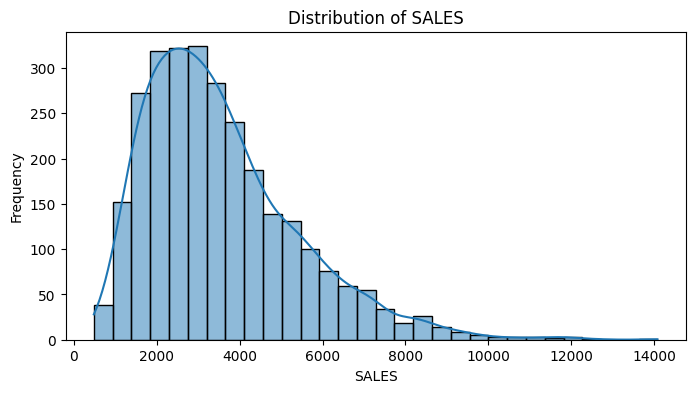

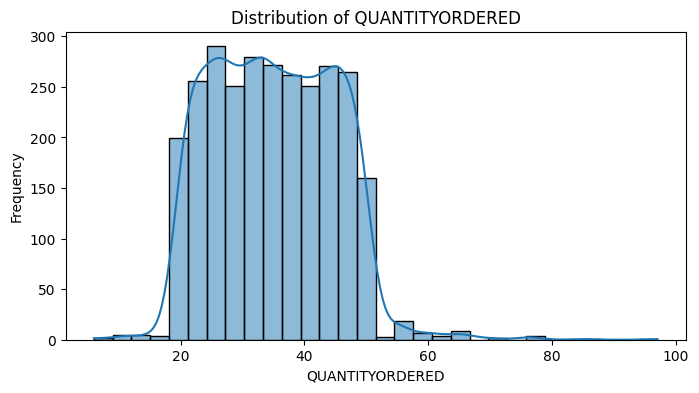

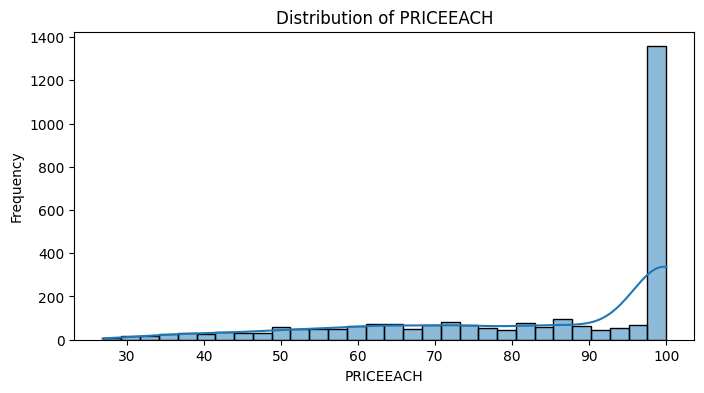

In [21]:
# 1️⃣ Numeric summaries of key measures
print("=== Numeric Summary ===")
display(df[['SALES', 'QUANTITYORDERED', 'PRICEEACH']].describe())

# 2️⃣ Categorical value counts
for col in ['PRODUCTLINE', 'COUNTRY', 'DEALSIZE']:
    print(f"\n=== Value Counts for {col} ===")
    display(df[col].value_counts())

numeric_cols = ['SALES', 'QUANTITYORDERED', 'PRICEEACH']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()


### Categorical Value Counts and Sales Analysis


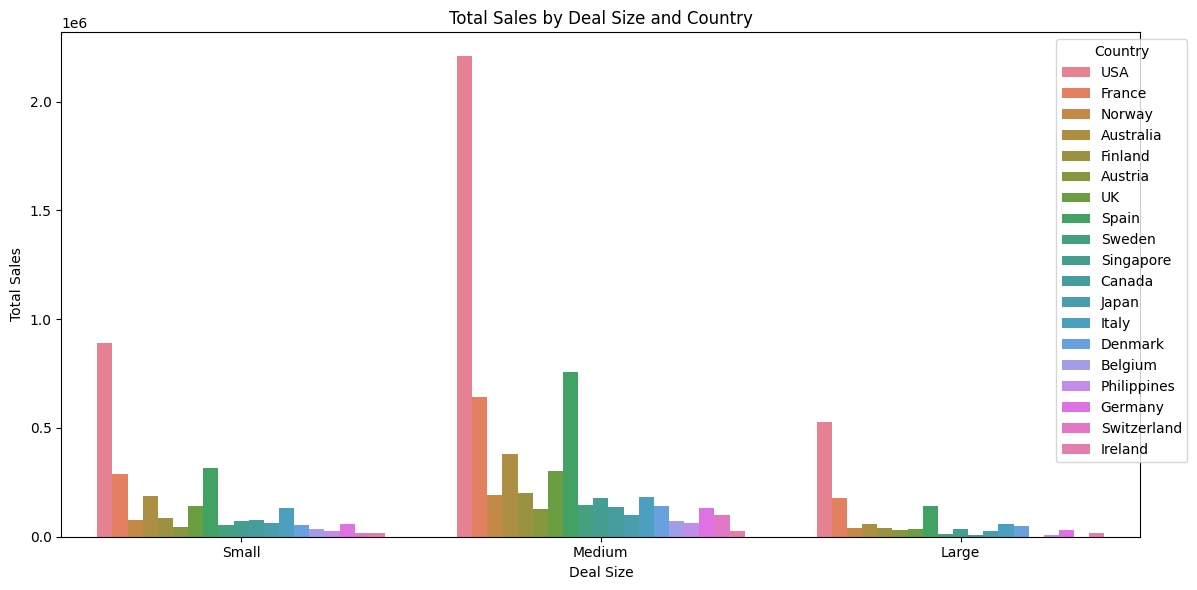

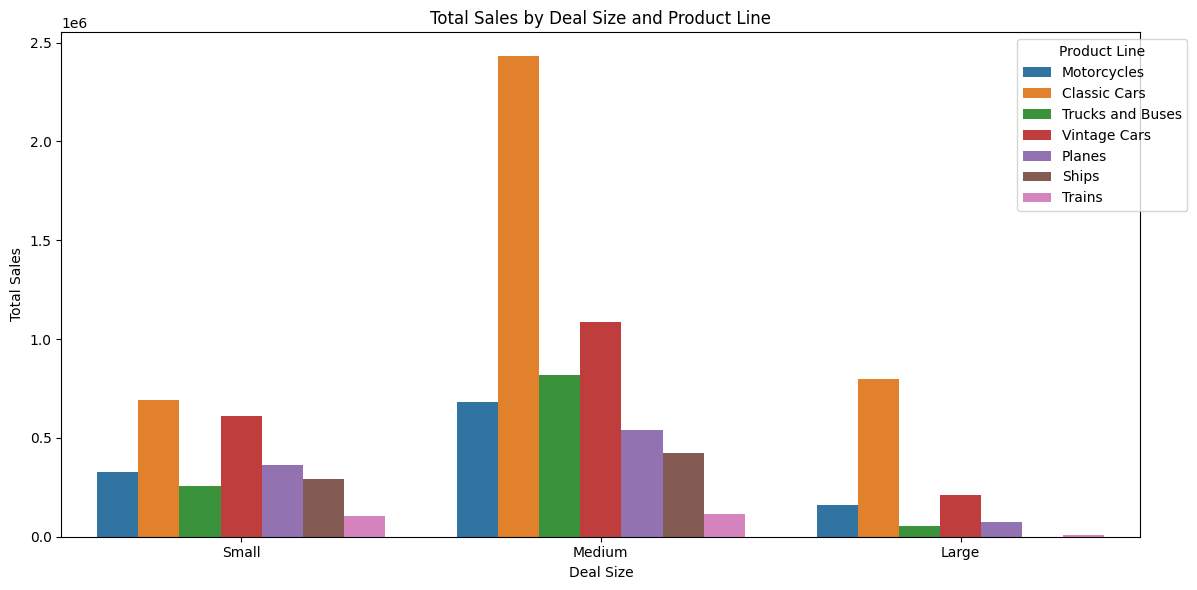

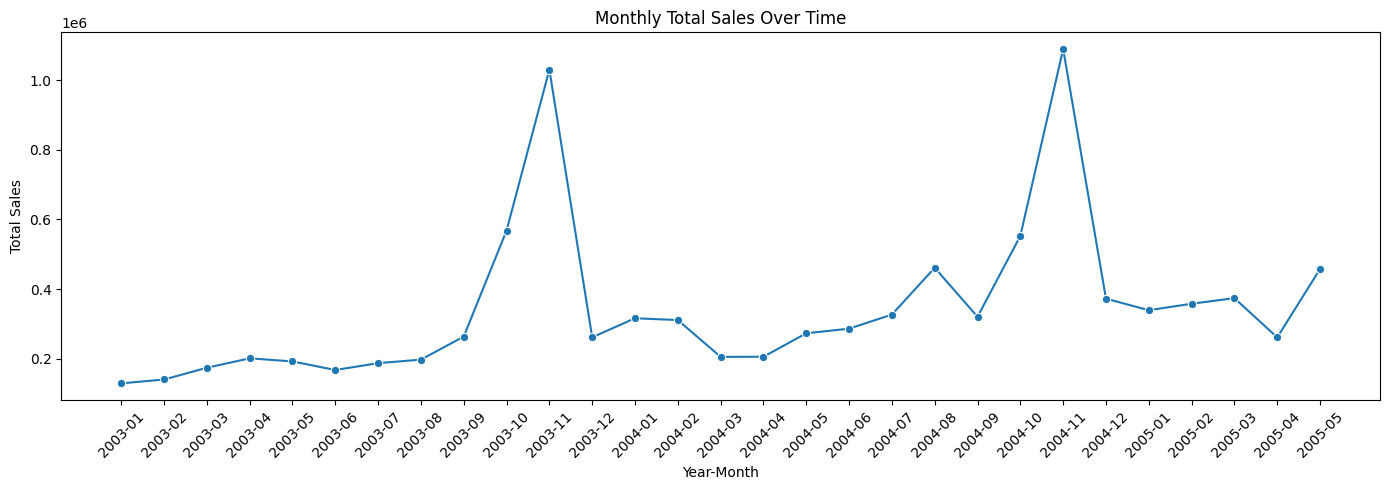

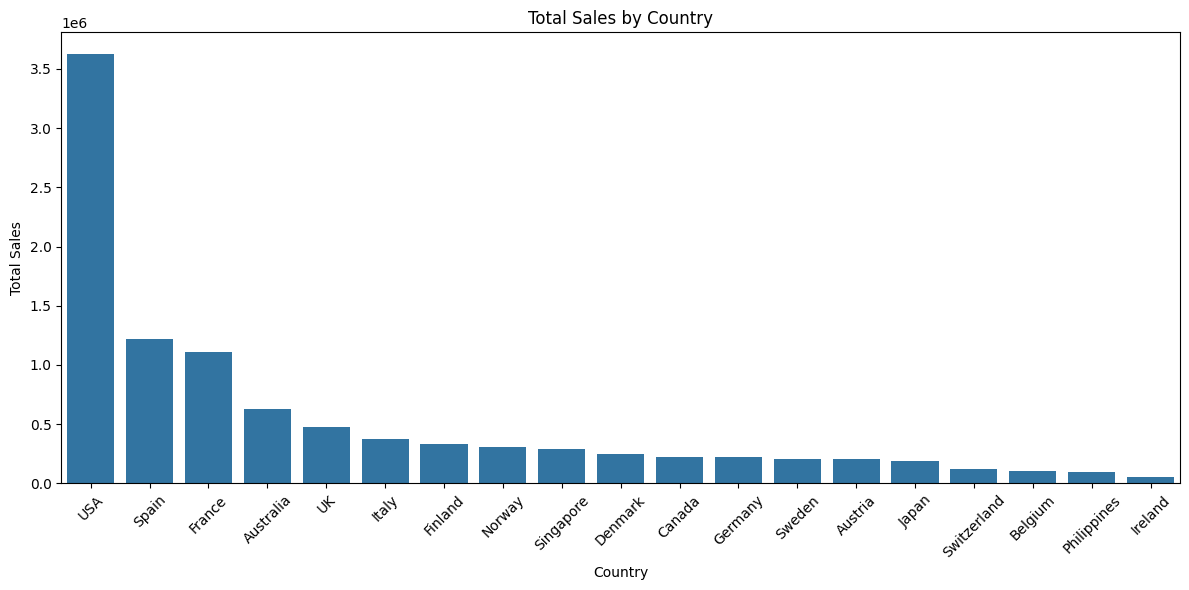

In [22]:
# 1️⃣ Deal Size & Purchase Behaviors by Country & Product
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='DEALSIZE',
    y='SALES',
    hue='COUNTRY',
    estimator=sum,
    errorbar=None # Changed ci to errorbar
)
plt.title('Total Sales by Deal Size and Country')
plt.xlabel('Deal Size')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05, 1), title='Country')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='DEALSIZE',
    y='SALES',
    hue='PRODUCTLINE',
    estimator=sum,
    errorbar=None # Changed ci to errorbar
)
plt.title('Total Sales by Deal Size and Product Line')
plt.xlabel('Deal Size')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05, 1), title='Product Line')
plt.tight_layout()
plt.show()

# Convert 'ORDERDATE' to datetime objects
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

# 2️⃣ Sales by Month & Seasonality
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').astype(str)
monthly = df.groupby('YearMonth')['SALES'].sum().reset_index()

plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly, x='YearMonth', y='SALES', marker='o')
plt.xticks(rotation=45)
plt.title('Monthly Total Sales Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

# 3️⃣ Sales by Geographic Region (Country)
country_sales = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=country_sales, x='COUNTRY', y='SALES')
plt.title('Total Sales by Country')
plt.xlabel('Country')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Data Preprocessing and Feature Engineering

### Data Quality Checks and Handling Missing Values

>>> DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHON

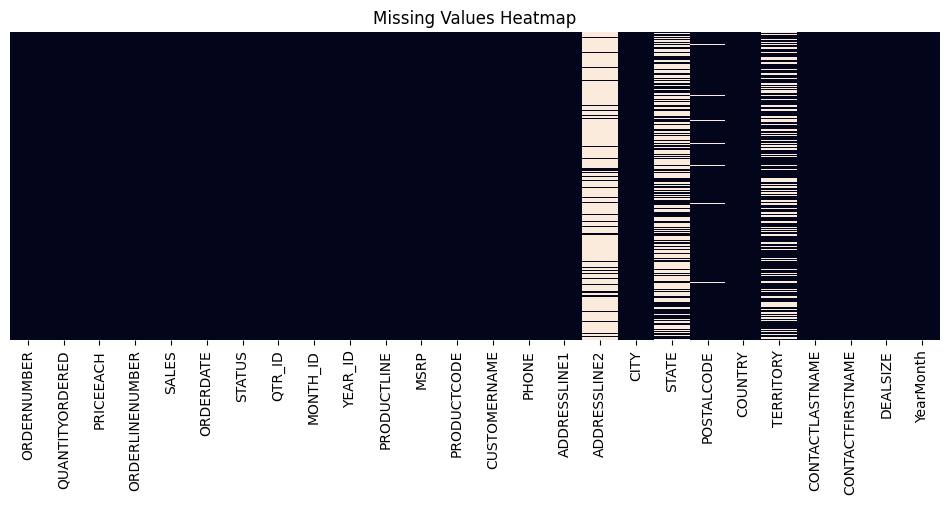


>>> New columns:
['year', 'month', 'total_rev_per_customer', 'order_count_per_customer', 'DEALSIZE_ord', 'PRODUCTLINE_Motorcycles', 'PRODUCTLINE_Planes', 'PRODUCTLINE_Ships', 'PRODUCTLINE_Trains', 'PRODUCTLINE_Trucks and Buses', 'PRODUCTLINE_Vintage Cars', 'COUNTRY_Austria', 'COUNTRY_Belgium', 'COUNTRY_Canada', 'COUNTRY_Denmark', 'COUNTRY_Finland', 'COUNTRY_France', 'COUNTRY_Germany', 'COUNTRY_Ireland', 'COUNTRY_Italy', 'COUNTRY_Japan', 'COUNTRY_Norway', 'COUNTRY_Philippines', 'COUNTRY_Singapore', 'COUNTRY_Spain', 'COUNTRY_Sweden', 'COUNTRY_Switzerland', 'COUNTRY_UK', 'COUNTRY_USA', 'STATUS_Disputed', 'STATUS_In Process', 'STATUS_On Hold', 'STATUS_Resolved', 'STATUS_Shipped']


In [23]:
# 4️⃣ Data Quality Checks: missing values & structure
print(">>> DataFrame Info:")
print(df.info(), "\n")
print(">>> Missing values per column:")
print(df.isnull().sum())

# Optional: visualize missingness

plt.figure(figsize=(12, 4))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

# 5️⃣ Handle missing/irrelevant columns
# Drop columns deemed secondary for this analysis
for col in ['PHONE', 'POSTALCODE', 'ADDRESSLINE2']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)

# Fill missing STATE with a placeholder
if 'STATE' in df.columns:
    df['STATE'] = df['STATE'].fillna('Missing')

# 6️⃣ Initial Feature Engineering
# Extract year & month from ORDERDATE (if not done)
df['year']  = df['ORDERDATE'].dt.year
df['month'] = df['ORDERDATE'].dt.month

# Total revenue and order count per customer
df['total_rev_per_customer']   = df.groupby('CUSTOMERNAME')['SALES'].transform('sum')
df['order_count_per_customer'] = df.groupby('CUSTOMERNAME')['ORDERNUMBER'].transform('nunique')

# 7️⃣ Encode categorical variables
# Ordinal encode DEALSIZE
deal_map = {'Small': 1, 'Medium': 2, 'Large': 3}
df['DEALSIZE_ord'] = df['DEALSIZE'].map(deal_map)

# One-hot encode PRODUCTLINE, COUNTRY, STATUS
df = pd.get_dummies(df, columns=[c for c in ['PRODUCTLINE','COUNTRY','STATUS'] if c in df.columns],
                    drop_first=True)

# 8️⃣ Verify new features
print("\n>>> New columns:")
print([c for c in df.columns if c.startswith(('year','month','total_rev','order_count','DEALSIZE_ord','PRODUCTLINE_','COUNTRY_','STATUS_'))])


### Further Data Cleaning and Feature Creation

In [24]:
# 1️⃣ Drop secondary columns with high missingness
# Removed dropping ADDRESSLINE2 and TERRITORY as they were already dropped

# 2️⃣ Fill STATE blanks with a placeholder,
df['STATE'] = df['STATE'].fillna('Unknown')

# 3️⃣ Extract year & month (again, if needed)
df['year']  = df['ORDERDATE'].dt.year
df['month'] = df['ORDERDATE'].dt.month

# 4️⃣ Customer‐level features
df['total_rev_per_customer']   = df.groupby('CUSTOMERNAME')['SALES'].transform('sum')
df['order_count_per_customer'] = df.groupby('CUSTOMERNAME')['ORDERNUMBER'].transform('nunique')

# 5️⃣ Encode DEALSIZE ordinally and one‐hot encode statuses
deal_map = {'Small': 1, 'Medium': 2, 'Large': 3}
df['DEALSIZE_ord'] = df['DEALSIZE'].map(deal_map)

# Removed duplicate one-hot encoding: df = pd.get_dummies(df, columns=['PRODUCTLINE','COUNTRY','STATUS'], drop_first=True)

# 6️⃣ Confirm
print(df.info())
print(df[['STATE','DEALSIZE_ord']].head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 54 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ORDERNUMBER                   2823 non-null   int64         
 1   QUANTITYORDERED               2823 non-null   int64         
 2   PRICEEACH                     2823 non-null   float64       
 3   ORDERLINENUMBER               2823 non-null   int64         
 4   SALES                         2823 non-null   float64       
 5   ORDERDATE                     2823 non-null   datetime64[ns]
 6   QTR_ID                        2823 non-null   int64         
 7   MONTH_ID                      2823 non-null   int64         
 8   YEAR_ID                       2823 non-null   int64         
 9   MSRP                          2823 non-null   int64         
 10  PRODUCTCODE                   2823 non-null   object        
 11  CUSTOMERNAME                  

 1️⃣ Save cleaned data
df.to_csv('cleaned_sales_data.csv', index=False)

2️⃣ Download file
from google.colab import files
files.download('cleaned_sales_data.csv')

# 3. second attempt (Partially passed)

### KMeans Algo

'''from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster       import AgglomerativeClustering
from sklearn.metrics       import silhouette_score
import numpy as np
import pandas as pd

# 1️⃣ Build RFM+ with AvgDealSize
snapshot = df['ORDERDATE'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE':   lambda x: (snapshot - x.max()).days,
    'ORDERNUMBER': 'nunique',
    'SALES':       'sum'
}).rename(columns={
    'ORDERDATE':   'Recency',
    'ORDERNUMBER': 'Frequency',
    'SALES':       'Monetary'
})
# Your extra customer features
rfm['TotalRev']     = rfm['Monetary']
rfm['AvgDealSize']  = df.groupby('CUSTOMERNAME')['DEALSIZE_ord'].mean()

# 2️⃣ MinMax scale
features = ['Recency','Frequency','Monetary','TotalRev','AvgDealSize']
X = MinMaxScaler().fit_transform(rfm[features])

# 3️⃣ Ward Hierarchical for k=3
k = 3
labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
score  = silhouette_score(X, labels)

# 4️⃣ Merge & report
rfm['Cluster_3'] = labels
df = df.merge(rfm[['Cluster_3']], on='CUSTOMERNAME', how='left')
print(f"Silhouette (k=3): {score:.3f}")
print("Cluster sizes:", np.bincount(labels))


### AgglomerativeClustering Algo (Best)

'''# 1️⃣ Build enriched RFM+ table
snapshot = df['ORDERDATE'].max() + pd.Timedelta(1, unit='D')
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE': lambda x: (snapshot - x.max()).days,
    'ORDERNUMBER': 'nunique',
    'SALES': 'sum',
    'CUSTOMERNAME':'size'
}).rename(columns={
    'ORDERDATE':'Recency',
    'ORDERNUMBER':'Frequency',
    'SALES':'Monetary',
    'CUSTOMERNAME':'OrderCount'  # duplicate of Frequency, optional
})
# add your total_rev_per_customer if not already here:
rfm['TotalRev'] = df.groupby('CUSTOMERNAME')['SALES'].sum()

# 2️⃣ Scale features
features = ['Recency','Frequency','Monetary','TotalRev']
X = StandardScaler().fit_transform(rfm[features])

# 3️⃣ Find best k by silhouette
from sklearn.cluster import AgglomerativeClustering
best_k, best_score = 2, -1
for k in range(2, 7):
    labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k} → silhouette={score:.2f}")
    if score > best_score:
        best_k, best_score = k, score

print(f"\n🎯 Best k = {best_k}, silhouette = {best_score:.2f}")

# 4️⃣ Final clustering
rfm['Cluster_Hier'] = AgglomerativeClustering(n_clusters=best_k, linkage='ward').fit_predict(X)

# 5️⃣ Merge back if you like
# Drop existing 'Cluster_Hier' columns if they exist before merging
df = df.drop(columns=[col for col in df.columns if 'Cluster_Hier' in col])
df = df.merge(rfm['Cluster_Hier'], on='CUSTOMERNAME', how='left')'''

### AgglomerativeClustering but only with k = 3

In [25]:
# 1️⃣ Build enriched RFM+ table (as before)
snapshot = df['ORDERDATE'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE':   lambda x: (snapshot - x.max()).days,
    'ORDERNUMBER': 'nunique',
    'SALES':       'sum',
    'CUSTOMERNAME':'size'
}).rename(columns={
    'ORDERDATE':      'Recency',
    'ORDERNUMBER':    'Frequency',
    'SALES':          'Monetary',
    'CUSTOMERNAME':   'OrderCount'
})
rfm['TotalRev'] = rfm['Monetary']  # same as SALES sum

# 2️⃣ Scale features
from sklearn.preprocessing import StandardScaler
features = ['Recency', 'Frequency', 'Monetary', 'TotalRev']
X = StandardScaler().fit_transform(rfm[features])

# 3️⃣ Manually set k = 3 for hierarchical clustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

k = 3
labels = AgglomerativeClustering(n_clusters=k, linkage='ward')\
         .fit_predict(X)
score = silhouette_score(X, labels)
print(f"Silhouette score for k={k}: {score:.3f}")

# 4️⃣ Assign and merge back
rfm['Cluster_Hier3'] = labels
df = df.drop(columns=[c for c in df.columns if c.startswith('Cluster_Hier')], errors='ignore')
df = df.merge(rfm[['Cluster_Hier3']], on='CUSTOMERNAME', how='left')

# 5️⃣ Quick check
print("Cluster sizes:", rfm['Cluster_Hier3'].value_counts())

Silhouette score for k=3: 0.553
Cluster sizes: Cluster_Hier3
0    78
2    12
1     2
Name: count, dtype: int64


In [26]:
# Re-add Cluster_GMM to rfm dataframe based on the previous GMM fitting
# This is necessary if rfm was modified after the GMM was run in cell Bc4XvMjMZibp
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np

# Assuming the GMM fitting in Bc4XvMjMZibp was the last one run that produced Cluster_GMM
# We need to re-apply the scaling and prediction to the current state of rfm

# Scale RFM features again (ensure consistency with GMM fitting)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

# Assuming best_k was determined in Bc4XvMjMZibp
# If not, you might need to re-run the BIC calculation or use a fixed k
# For now, assuming k=3 is available from the previous run (which it is in the notebook state)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(rfm_scaled) # Re-fit GMM to get predictable labels
rfm['Cluster_GMM'] = gmm.predict(rfm_scaled) # Predict labels for the current rfm

profile = rfm.groupby('Cluster_GMM')[['Recency','Frequency','Monetary']].mean().round(1)
print("Cluster profiles:\n", profile)

Cluster profiles:
              Recency  Frequency  Monetary
Cluster_GMM                              
0              126.9        3.3  104459.5
1                2.0       21.5  783576.1
2              326.7        2.0   69797.3


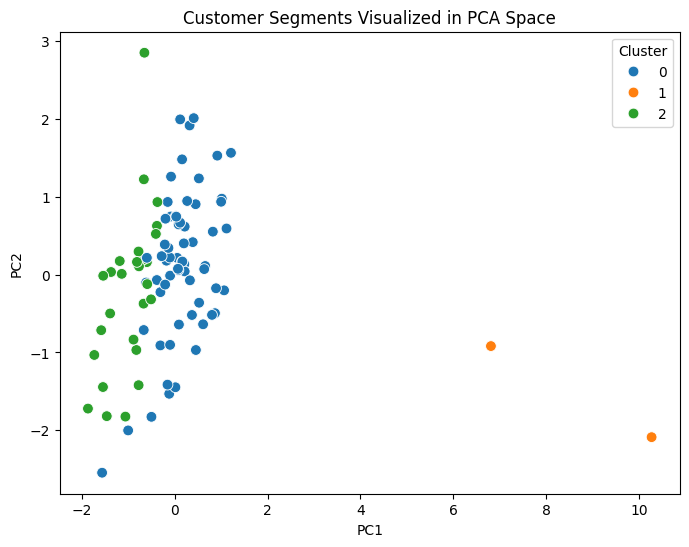

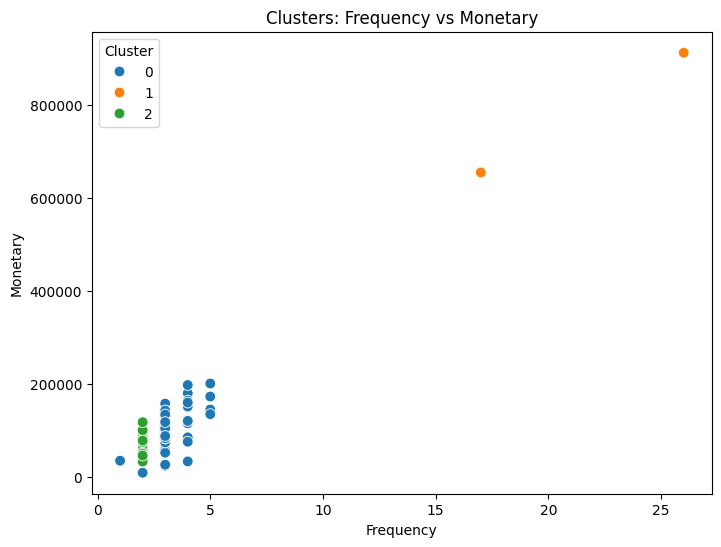

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1️⃣ Prepare PCA projection

# Recalculate AvgDealSize and add to rfm DataFrame
# Assuming 'DEALSIZE_ord' was created earlier and is available in df
if 'DEALSIZE_ord' in df.columns:
    rfm['AvgDealSize'] = df.groupby('CUSTOMERNAME')['DEALSIZE_ord'].mean()
else:
    print("Warning: 'DEALSIZE_ord' not found in df. Skipping AvgDealSize calculation.")
    # If 'DEALSIZE_ord' is not available, you might need to adjust the features list

features = ['Recency', 'Frequency', 'Monetary'] # Start with RFM features
if 'AvgDealSize' in rfm.columns: # Add AvgDealSize only if it was successfully created
    features.append('AvgDealSize')
else:
     print("PCA will be performed without AvgDealSize due to missing data.")


X = StandardScaler().fit_transform(rfm[features])
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X)
rfm['PC1'], rfm['PC2'] = pc[:,0], pc[:,1]

# 2️⃣ PCA scatter plot
plt.figure(figsize=(8,6))
# Use 'Cluster_GMM' as the hue, as 'Cluster_Refined' is not present
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_GMM', data=rfm, palette='tab10', s=60)
plt.title('Customer Segments Visualized in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

# 3️⃣ Feature-space scatter plot (Frequency vs Monetary)
plt.figure(figsize=(8,6))
# Use 'Cluster_GMM' as the hue
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster_GMM', data=rfm, palette='tab10', s=60)
plt.title('Clusters: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()

In [28]:
from sklearn.metrics import silhouette_samples
scores = silhouette_samples(rfm_scaled, rfm['Cluster_GMM'])
rfm['Silhouette'] = scores
print(rfm.groupby('Cluster_GMM')['Silhouette'].mean().round(2))


Cluster_GMM
0    0.41
1    0.54
2    0.38
Name: Silhouette, dtype: float64


In [29]:
# Aggregate sales by month
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('YearMonth')['SALES'].sum().reset_index()
monthly.columns = ['ds','y']


In [30]:
!pip install prophet --quiet
from prophet import Prophet

m = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
m.fit(monthly)
future = m.make_future_dataframe(periods=6, freq='ME')
forecast = m.predict(future)


INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoifw10tg/x4zyq81n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoifw10tg/45c2ogdf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=47336', 'data', 'file=/tmp/tmpoifw10tg/x4zyq81n.json', 'init=/tmp/tmpoifw10tg/45c2ogdf.json', 'output', 'file=/tmp/tmpoifw10tg/prophet_modelfvu86a9u/prophet_model-20250710033533.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:35:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:35:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


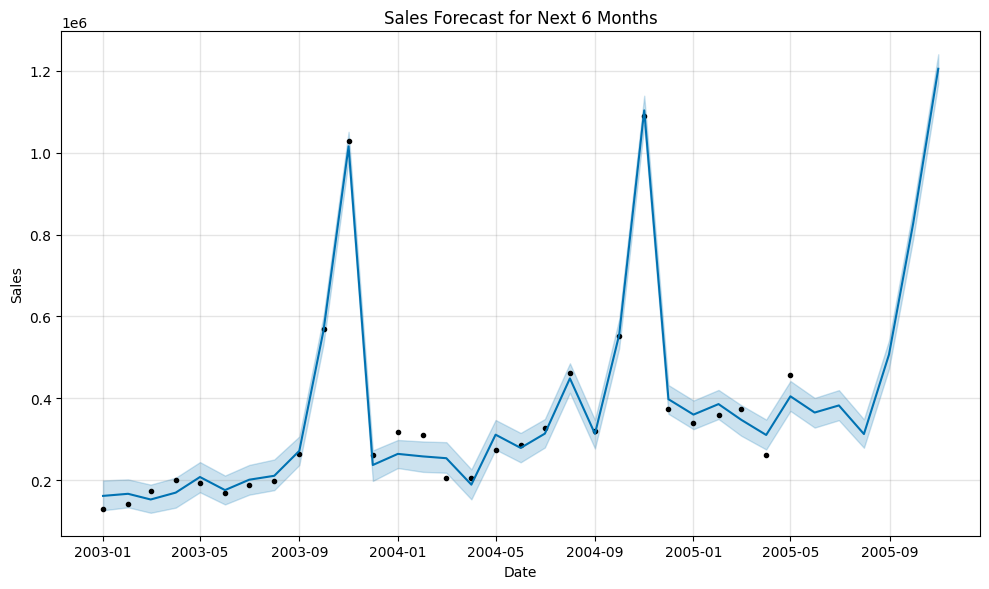

🔝 Top Predicted Sales Months:
           ds          yhat
34 2005-10-31  1.205186e+06
33 2005-09-30  8.275809e+05
32 2005-08-31  5.067320e+05
30 2005-06-30  3.825878e+05
29 2005-05-31  3.652352e+05
31 2005-07-31  3.127090e+05


In [31]:
# === 📈 Forecast Plot ===
import matplotlib.pyplot as plt

fig = m.plot(forecast)
plt.title("Sales Forecast for Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# === 🔍 Identify High-Conversion Months ===
# Show only future predictions
future_forecast = forecast[forecast['ds'] > monthly['ds'].max()]
top_months = future_forecast[['ds', 'yhat']].sort_values('yhat', ascending=False)

print("🔝 Top Predicted Sales Months:")
print(top_months)  # Adjust number as needed


In [32]:
# === 🛒 Convert Data to Basket Format for Apriori ===
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Group product names by order - Use 'PRODUCTCODE' instead of 'PRODUCTLINE'
baskets = df.groupby('ORDERNUMBER')['PRODUCTCODE'].apply(list).values.tolist()

# Transform to binary matrix
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# === 📊 Find Frequent Itemsets ===
frequent_itemsets = apriori(basket_df, min_support=0.02, use_colnames=True)

# === 🔗 Generate Association Rules ===
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False)

# === 🔍 View Top Rules ===
print("📦 Top Product Association Rules:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))

📦 Top Product Association Rules:


,antecedents,consequents,support,confidence,lift
2392702,"(S24_3420, S50_1341, S18_3856)","(S700_2047, S700_4002, S700_1691, S700_3167, S...",0.022801,1.0,43.857143
2389024,"(S24_3420, S700_3167, S50_1341, S18_3856)","(S700_2047, S700_1691, S24_3949, S24_2841, S70...",0.022801,1.0,43.857143
1976613,"(S700_1691, S700_2466, S18_3856)","(S50_1341, S700_2047, S24_3949, S700_3167, S24...",0.022801,1.0,43.857143
220694,"(S18_2957, S24_1937, S18_1367)","(S18_2325, S18_3136)",0.022801,1.0,43.857143
1974581,"(S700_1691, S700_2466, S18_3856)","(S50_1341, S700_2047, S24_3420, S700_3167, S24...",0.022801,1.0,43.857143


In [33]:
# === 💳 Customer Lifetime Value Prediction (Step 7) ===

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Define features and target
features = ['Recency', 'Frequency', 'OrderCount']
target = 'Monetary'

X = rfm[features]
y = rfm[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate model
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 R² Score: {r2:.2f}")
print(f"📉 Mean Absolute Error: {mae:.2f}")

# Predict and rank customers
rfm['LTV_Predicted'] = rf.predict(rfm[features])
top_customers = rfm[['LTV_Predicted']].sort_values(by='LTV_Predicted', ascending=False)

print("\n🔝 Top 10 High-Value Customers (Predicted LTV):")
display(top_customers.head(10))

📊 R² Score: 0.93
📉 Mean Absolute Error: 21546.48

🔝 Top 10 High-Value Customers (Predicted LTV):


,LTV_Predicted
CUSTOMERNAME,
Euro Shopping Channel,613029.0887
Mini Gifts Distributors Ltd.,540682.5128
La Rochelle Gifts,259185.0026
"Australian Collectors, Co.",192840.1679
Muscle Machine Inc,187872.8468
Rovelli Gifts,177842.8727
Land of Toys Inc.,175676.5494
"AV Stores, Co.",175282.7905
Souveniers And Things Co.,164154.0105


In [34]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

# ── Prepare data ───────────────────────────────────────
X = rfm[['Recency', 'Frequency', 'OrderCount']]
y = rfm['Monetary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ── Build & train pipeline ────────────────────────────
pipe = Pipeline([('rf', RandomForestRegressor(n_estimators=100, random_state=42))])
pipe.fit(X_train, y_train)

# ── Evaluate ───────────────────────────────────────────
y_pred = pipe.predict(X_test)
metrics = {
    'R2': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred)
}
print("Model Performance:")
print(pd.DataFrame.from_dict(metrics, orient='index', columns=['Score']).round(2))

# ── Predict & rank customers ──────────────────────────
rfm['LTV_Predicted'] = pipe.predict(X)
top10 = rfm[['LTV_Predicted']].nlargest(10, 'LTV_Predicted')
print("\nTop 10 Customers by Predicted LTV:")
print(top10)


Model Performance:
        Score
R2       0.93
MAE  21546.48

Top 10 Customers by Predicted LTV:
                              LTV_Predicted
CUSTOMERNAME                               
Euro Shopping Channel           613029.0887
Mini Gifts Distributors Ltd.    540682.5128
La Rochelle Gifts               259185.0026
Australian Collectors, Co.      192840.1679
Muscle Machine Inc              187872.8468
Rovelli Gifts                   177842.8727
Land of Toys Inc.               175676.5494
AV Stores, Co.                  175282.7905
Souveniers And Things Co.       164154.0105
Dragon Souveniers, Ltd.         162639.2103


/tmp/ipython-input-35-459407912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.index, y='LTV_Predicted', data=top10, palette='viridis')


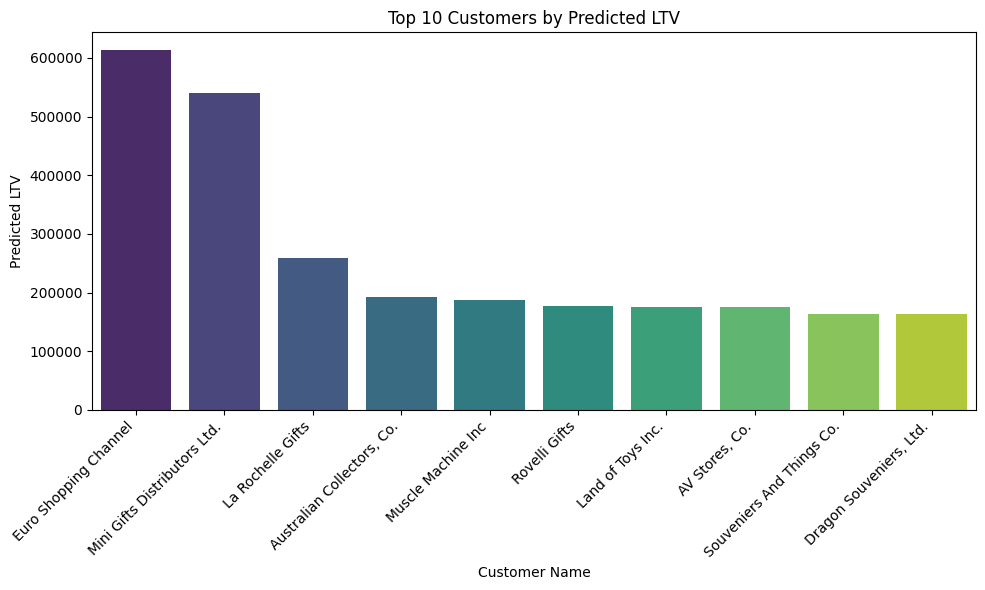

In [35]:
# Visualize the top 10 customers by predicted LTV
plt.figure(figsize=(10, 6))
sns.barplot(x=top10.index, y='LTV_Predicted', data=top10, palette='viridis')
plt.title('Top 10 Customers by Predicted LTV')
plt.xlabel('Customer Name')
plt.ylabel('Predicted LTV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()